# Project SpaceJam

- Data Loading
- Model
- Training + Discussion
- Test + Discussion
- Test suite (load pretrained, test dataset)

In [1]:
SEED = 9126

import os
import json
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

run on cuda


In [2]:
DATASET_DIR = 'dataset'
DATASET_FILES = 'dataset/examples'
KEYSET_FILE = 'testset_keys.txt'

labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

with open(os.path.join(DATASET_DIR, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)    

In [3]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTrain), len(annotationTest)

(37085, 25959, 11126)

Shape torch.Size([16, 3, 176, 128])


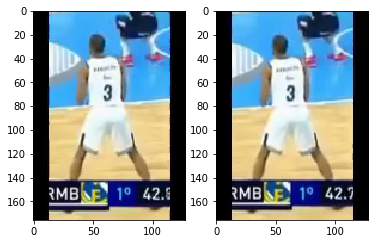

In [4]:
transform= torchvision.transforms.ToTensor()

image = []
          
fname = os.path.join(DATASET_FILES, '0018414.mp4')
video = cv2.VideoCapture(fname)
while True:
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame = transform(Image.fromarray(frame))
        image.append(frame.unsqueeze(0))
    else:
        break

image = torch.cat(image, axis=0)

print('Shape', image.shape)

plt.subplot(121)
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(image[1].numpy().transpose(1, 2, 0));


In [5]:
class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 10)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

    def forward(self, x):

        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        logits = self.fc8(h)

        return logits
    
MyModel()

MyModel(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3), str

# Test suite
    
    dataset = ...
    model = load_model(...)
    
    y_true, y_pred = classify(model, dataset)

    report = classification_report(y_true, y_pred)
    print(report)